## 3. Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
from collections import defaultdict

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import accuracy

In [2]:
plt.style.use('ggplot')

plt.rcParams['lines.markersize'] = 10
plt.rcParams['font.size'] =17
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams[ 'figure.dpi']= 100
plt.rcParams['axes.titlepad']= 15.0
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize'] ='small'

plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1

In [3]:
def ax_labels(ax, x='', y='', title=''):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    return ax

In [4]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [6]:
# Load ratings df
ratings = pd.read_csv('../../csv2/combined/CA_review_cleaned.csv')
ratings.shape

(484255, 15)

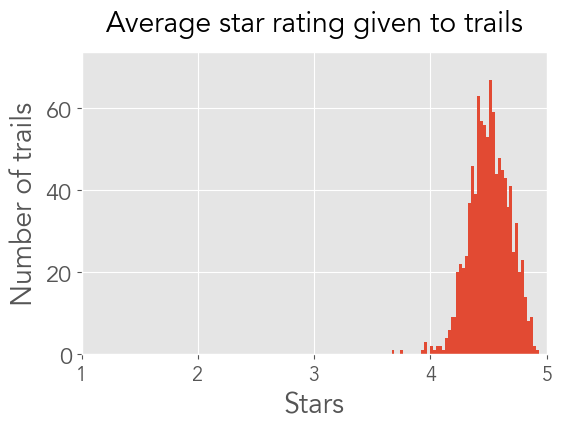

In [529]:
a = ratings.groupby('trail').mean()

ax = a['stars'].hist(bins=50)
ax.set_xlim(1,5)
ax = ax_labels(ax, 'Stars', 'Number of trails', 'Average star rating given to trails' )

(0.0, 30.0)

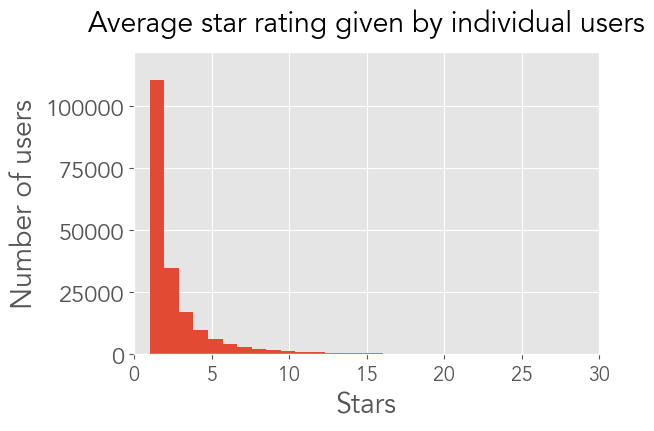

In [16]:
b = ratings.groupby('user_id').count()
ax = b['stars'].hist(bins=120)

ax = ax_labels(ax, 'Stars', 'Number of users', 'Average star rating given by individual users' )
ax.set_xlim(0,30)

In [1213]:
b[b['stars']<6].count()/195869

user_name            0.910083
trail                0.910083
trail_url            0.910083
stars                0.910083
date                 0.910083
review_text          0.910083
trail_avg_star       0.910083
difficulty           0.910083
distance             0.910083
elevation            0.910083
route_type           0.910083
location             0.910083
tag_list             0.910083
short_description    0.910083
dtype: float64

In [1209]:
b

,user_name,trail,trail_url,stars,date,review_text,trail_avg_star,difficulty,distance,elevation,route_type,location,tag_list,short_description
user_id,,,,,,,,,,,,,,
0,1,1,1,1,1,0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,1,1,1,1,1,1,1,1
2,15,15,15,15,15,14,15,15,15,15,15,15,15,15
3,22,22,22,22,22,18,22,22,22,22,22,22,22,22
4,1,1,1,1,1,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195864,2,2,2,2,2,0,2,2,2,2,2,2,2,2
195865,1,1,1,1,1,0,1,1,1,1,1,1,1,1
195866,1,1,1,1,1,0,1,1,1,1,1,1,1,1


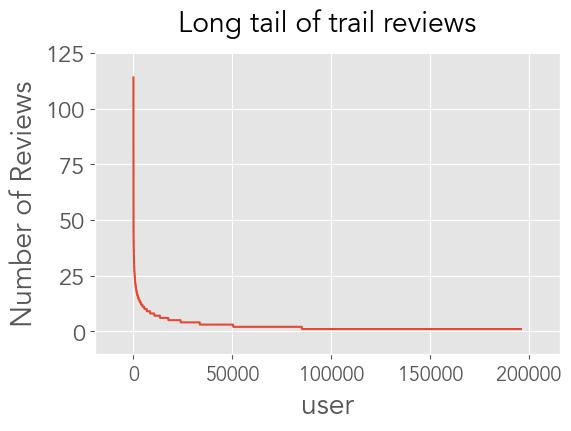

In [17]:
long_tail = b.sort_values('trail', ascending=False).reset_index()
a=list(long_tail.index)
b=long_tail['user_name']
fig, ax = plt.subplots()
ax.plot(a,b)
ax = ax_labels(ax, 'user', 'Number of Reviews', 'Long tail of trail reviews')
plt.show()

In [ ]:
long_tail = d.sort_values('user_name', ascending=False).reset_index()
a=list(long_tail.index)
b=long_tail['user_name']
fig, ax = plt.subplots()
ax.plot(a,b)
ax = ax_labels(ax, 'Trails', 'Number of Reviews', 'Long tail of trail reviews')
plt.show()

## Calculating sparsity and selecting data to get 8% for collaborative filtering

I discarded users with 10 or less reviews & trails with less than 65 reviews in order to achieve 2.5% sparsity

In [530]:
trail_review_count = ratings.groupby('trail_url').count().sort_values('user_name', ascending = False)

In [752]:
## Pipeline for discarding some users & trails to increase matrix sparsity
def reduce_df(ratings, i=50, j=10): # i = trail_review_threshhold, j = user_review_threshhold
    trail_review_count = ratings.groupby('trail_url').count().sort_values('user_name', ascending = False)
    
    trail_more_than_i = trail_review_count[trail_review_count['user_name']>=i]
    ratings_trail = ratings[ratings['trail_url'].isin(trail_more_than_i.index)]
    
    
    user_review_count = ratings_trail.groupby('user_name').count().sort_values('trail_url', ascending = False)
    
    user_more_than_j  = user_review_count[user_review_count['trail_url']>=j]
    ratings_user = ratings_trail[ratings_trail['user_name'].isin(user_more_than_j.index)]
    
    n_users = ratings_user['user_name'].nunique()
    n_trails = ratings_user['trail_url'].nunique()
    n_reviews = ratings_user.shape[0]
    
    print(n_users,n_trails,n_reviews)
    
    sparsity = 100* n_reviews/(n_users*n_trails)
    #sparsity >=2.5:
    print(' threshhold for # of ratings (trail, user) |    n_users    |    n_trails    |   n_reviews    | % sparsity ')
    print('----------------------------------------------------------------------------------------------------------')
    print(f'                  {i,j}                 |      {n_users}     |       {n_trails}      |   {n_reviews}        |   {sparsity:.2f}')
     
    ratings_user['user_id'] = ratings_user['user_name'].astype('category').cat.codes
    ratings_user['trail_id'] = ratings_user['trail_url'].astype('category').cat.codes
    
    return ratings_user

In [751]:
## Generates df with small set of data for collaborative filtering
def create_small_df(f,i,j):
    df_small = f(i,j)
    df_small['user_id'] = df_small['user_name'].astype('category').cat.codes
    df_small['trail_id'] = df_small['trail_url'].astype('category').cat.codes
    df_small.head()
    return df_small

## Modeling

In [566]:
reader=Reader()
data = Dataset.load_from_df(df_small_3[['user_id', 'trail_id', 'stars']], reader)
algo=SVDpp()

trainset = data.build_full_trainset()
algo.fit(trainset)

In [567]:
## Generate ratings for all trails for users in user list
def full_predictions(user_list):
    pred = []
    for i in list(user_list):
        for j in range(df_small_3['trail_id'].nunique()):
            pred.append(algo.predict(i,j))
    return pred

In [568]:
## Get full prediction on all users
pred_all = full_predictions(all_users)
all_user_full_predicted = pd.DataFrame(pred)   # In df format
all_user_full_predicted.columns = ['user_id','trail_id','stars_real','stars_predicted','details'] 

In [569]:
## Get predictions for super users
pred = full_predictions(super_users)
super_user_full_predicted = pd.DataFrame(pred)   # In df format
super_user_full_predicted.columns = ['user_id','trail_id','stars_real','stars_predicted','details'] 

In [744]:
## Generates dictionary for user-top10 rec pairs from a given prediction
def get_top_n(pred, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in pred:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    a = []
    for key,value in top_n.items():
        a.append((key,[i[0] for i in value]))
    
    return top_n

In [745]:
## Get top n recommendations for each user in super user set
super_user_recommendations = get_top_n(pred)
all_user_recommendations = get_top_n(pred_all)

In [746]:
def prf(recommendations, df_small_3):
    precisions=[]
    recalls = []
    for key in recommendations:
        recommended = [i[0] for i in recommendations[key]]
        rated = list(df_small_3[df_small_3['user_id']==key].trail_id.unique())

        precision = len([trail for trail in recommended if trail in rated])/len(recommended)
        recall =  len([trail for trail in rated if trail in recommended])/len(rated)
        
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

In [767]:
def random_prf(recommendations, df_small_3, n):
    precisions=[]
    recalls = []
    for key in recommendations:
        recommended = np.random.choice(small_df.trail_id.unique(), n, replace = False)
        rated = list(df_small_3[df_small_3['user_id']==key].trail_id.unique())

        precision = len([trail for trail in recommended if trail in rated])/len(recommended)
        recall =  len([trail for trail in rated if trail in recommended])/len(rated)
        
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

In [747]:
prf(super_user_recommendations, super_user_rated)

(0.03324022346368715, 0.0062387952662507065)

## Start comparing models

In [805]:
small_df = reduce_df(ratings,800,10)
small_df.drop('user_name', axis=1, inplace=True)

784 145 10190
 threshhold for # of ratings (trail, user) |    n_users    |    n_trails    |   n_reviews    | % sparsity 
----------------------------------------------------------------------------------------------------------
                  (800, 10)                 |      784     |       145      |   10190        |   8.96


<ipython-input-752-e660abb521cf>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_user['user_id'] = ratings_user['user_name'].astype('category').cat.codes
<ipython-input-752-e660abb521cf>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_user['trail_id'] = ratings_user['trail_url'].astype('category').cat.codes


In [941]:
len(super_users)

784

## SVD model

In [820]:
factors_list=[]
SVD_pre = []

for i in range(50,500,50):
    reader=Reader()
    data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
    algo=SVD(n_factors=i)

    trainset = data.build_full_trainset()
    algo.fit(trainset)


    k=5
    super_user_thresh = 10

    a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
    super_users =list(a[a['trail']>=super_user_thresh].index)

    pred = full_predictions(super_users)
    recommendations = get_top_n(pred, k)
    
    factors_list.append(i)
    SVD_pre.append(prf(recommendations, small_df))
    
SVD_pre_rand=random_prf(recommendations, small_df, k)

n-factors

In [821]:
SVD_pre

[(0.10510204081632654, 0.040566819344537125),
 (0.10510204081632654, 0.039851488149901346),
 (0.1239795918367347, 0.047683390743319225),
 (0.13163265306122449, 0.05057501320332362),
 (0.12908163265306125, 0.04932126586937588),
 (0.14566326530612247, 0.05577160419208881),
 (0.1433673469387755, 0.05389748700063502),
 (0.14311224489795918, 0.05511215283207222),
 (0.13954081632653062, 0.05300528502451592)]

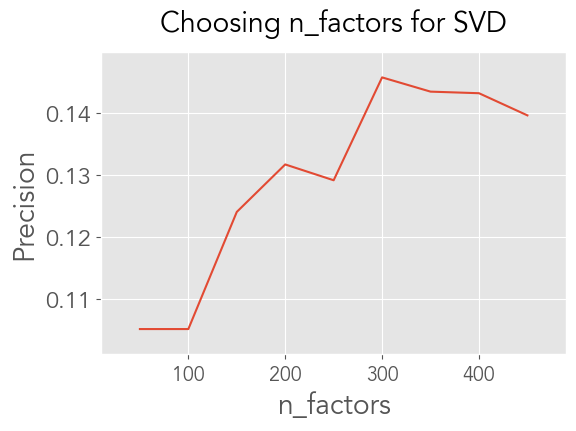

In [829]:
fig,ax = plt.subplots()
ax.plot(factors_list, [i[0] for i in SVD_pre])
ax=ax_labels(ax, 'n_factors', 'Precision', 'Choosing n_factors for SVD' )

## SVDpp model

In [826]:
SVDpp_factors_list=[]
SVDpp_pre = []

for i in range(50,500,50):
    reader=Reader()
    data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
    algo=SVDpp(n_factors=i)

    trainset = data.build_full_trainset()
    algo.fit(trainset)


    k=5
    super_user_thresh = 10

    a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
    super_users =list(a[a['trail']>=super_user_thresh].index)

    pred = full_predictions(super_users)
    recommendations = get_top_n(pred, k)
    
    SVDpp_factors_list.append(i)
    SVDpp_pre.append(prf(recommendations, small_df))
    
SVDpp_pre_rand=random_prf(recommendations, small_df, k)

In [894]:
SVDpp_pre

[(0.12244897959183673, 0.046999077030090736),
 (0.15051020408163265, 0.05887442155811318),
 (0.15612244897959185, 0.0605446678253092),
 (0.17882653061224488, 0.0684527976081366),
 (0.19005102040816327, 0.07389791072304418),
 (0.20178571428571426, 0.07816366523141542),
 (0.21658163265306124, 0.08282354421436643),
 (0.20510204081632655, 0.07976175195942661),
 (0.20306122448979594, 0.0791381511779291)]

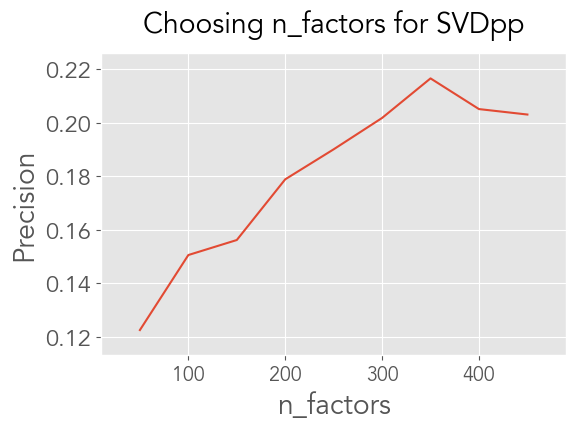

In [939]:
fig,ax = plt.subplots()
ax.plot(SVDpp_factors_list, [i[0] for i in SVDpp_pre])
ax=ax_labels(ax, 'n_factors', 'Precision', 'Choosing n_factors for SVDpp' )

## NMF Model

In [840]:
NMF_factors_list=[]
NMF_pre = []

for i in range(10,50,10):
    reader=Reader()
    data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
    algo=NMF(n_factors=i)

    trainset = data.build_full_trainset()
    algo.fit(trainset)


    k=5
    super_user_thresh = 10

    a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
    super_users =list(a[a['trail']>=super_user_thresh].index)

    pred = full_predictions(super_users)
    recommendations = get_top_n(pred, k)
    
    NMF_factors_list.append(i)
    NMF_pre.append(prf(recommendations, small_df))
    
NMF_pre_rand=random_prf(recommendations, small_df, k)

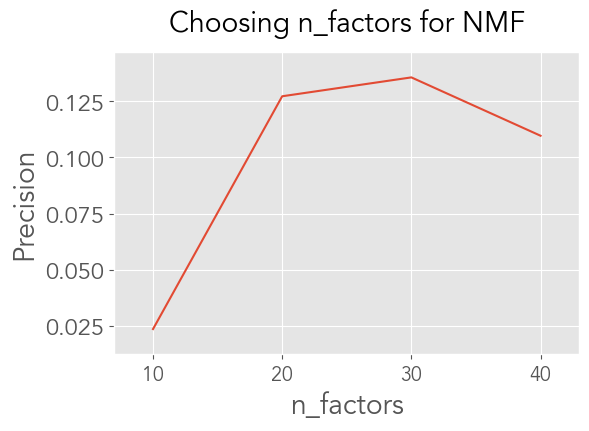

In [841]:
fig,ax = plt.subplots()
ax.plot(NMF_factors_list, [i[0] for i in NMF_pre])
ax=ax_labels(ax, 'n_factors', 'Precision', 'Choosing n_factors for NMF' )

In [893]:
[i[0] for i in NMF_pre]

[0.023469387755102038,
 0.12729591836734694,
 0.13571428571428573,
 0.1096938775510204]

## User-User similairty

In [847]:
knn_user_factors_list=[]
knn_pre = []

for nn in range(10,300,20):
    reader=Reader()
    data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
    algo=KNNBasic(k=nn)

    trainset = data.build_full_trainset()
    algo.fit(trainset)


    k=5
    super_user_thresh = 10

    a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
    super_users =list(a[a['trail']>=super_user_thresh].index)
 
    pred = full_predictions(super_users)
    recommendations = get_top_n(pred, k)
    
    knn_user_factors_list.append(nn)
    knn_pre.append(prf(recommendations, small_df))
    
knn_pre_rand=random_prf(recommendations, small_df, k)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

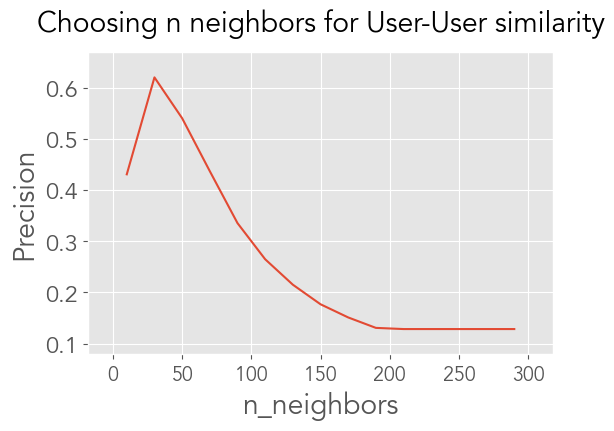

In [858]:
fig,ax = plt.subplots()
ax.plot(knn_user_factors_list, [i[0] for i in knn_pre])
ax=ax_labels(ax, 'n_neighbors', 'Precision', 'Choosing n neighbors for User-User similarity' )

In [855]:
knn_trail_factors_list=[]
knn_trail_pre = []

for nn in range(2,10,1):
    reader=Reader()
    data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
    
    
    sim_options = { 'user_based': False } # compute  similarities between items
    algo = KNNBasic(k=nn,sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo.fit(trainset)


    k=5
    super_user_thresh = 10

    a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
    super_users =list(a[a['trail']>=super_user_thresh].index)

    pred = full_predictions(super_users)
    recommendations = get_top_n(pred, k)
    
    knn_trail_factors_list.append(nn)
    knn_trail_pre.append(prf(recommendations, small_df))
    
knn_pre_rand=random_prf(recommendations, small_df, k)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [895]:
knn_trail_pre

[(0.10586734693877552, 0.03960003175708009),
 (0.13239795918367347, 0.04981092448627857),
 (0.15127551020408161, 0.057189403730341266),
 (0.15969387755102038, 0.05934503211561903),
 (0.15229591836734693, 0.05639193457535113),
 (0.14387755102040817, 0.05104692741036183),
 (0.13214285714285715, 0.046207147845557815),
 (0.11581632653061226, 0.03876317420019937)]

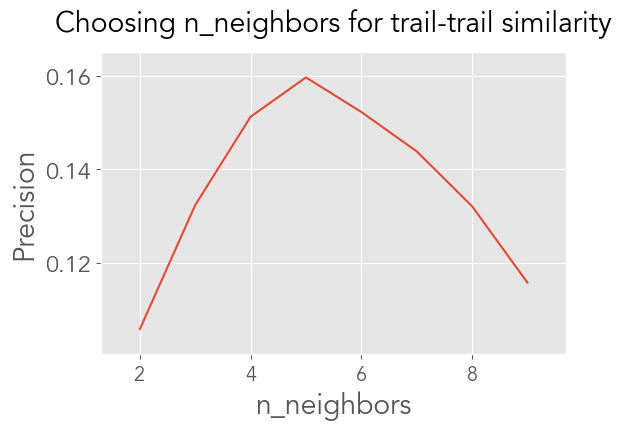

In [857]:
fig,ax = plt.subplots()
ax.plot(knn_trail_factors_list, [i[0] for i in knn_trail_pre])
ax=ax_labels(ax, 'n_neighbors', 'Precision', 'Choosing n_neighbors for trail-trail similarity' )

## Fine tuning user-user similarity model

In [861]:
knn_user_factors_list=[]
knn_pre = []

for nn in range(20,40,2):
    reader=Reader()
    data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
    algo=KNNBasic(k=nn)

    trainset = data.build_full_trainset()
    algo.fit(trainset)


    k=5
    super_user_thresh = 10

    a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
    super_users =list(a[a['trail']>=super_user_thresh].index)
 
    pred = full_predictions(super_users)
    recommendations = get_top_n(pred, k)
    
    knn_user_factors_list.append(nn)
    knn_pre.append(prf(recommendations, small_df))
    
knn_pre_rand=random_prf(recommendations, small_df, k)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [896]:
knn_pre

[(0.5923469387755101, 0.23857895215040442),
 (0.6068877551020407, 0.2445661315434791),
 (0.6204081632653061, 0.2501771351922702),
 (0.6234693877551021, 0.25153187017554457),
 (0.6232142857142857, 0.2511637845465811),
 (0.6204081632653061, 0.24971026009276318),
 (0.6117346938775511, 0.24596524036158746),
 (0.6091836734693877, 0.2445509162302489),
 (0.6040816326530613, 0.24241098433341426),
 (0.5938775510204081, 0.23828960557871548)]

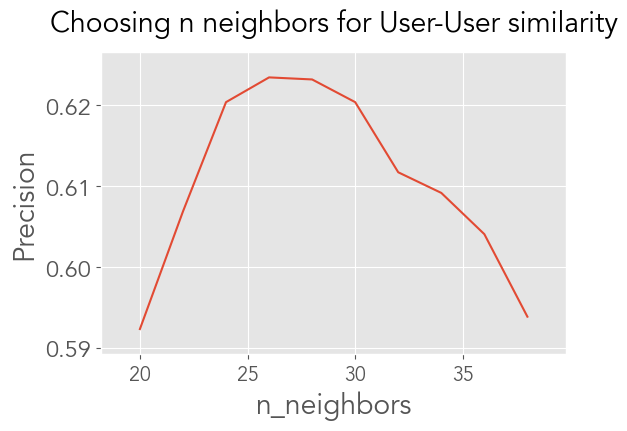

In [862]:
fig,ax = plt.subplots()
ax.plot(knn_user_factors_list, [i[0] for i in knn_pre])
ax=ax_labels(ax, 'n_neighbors', 'Precision', 'Choosing n neighbors for User-User similarity' )

In [869]:
k_values=[]
precisions=[]

for i in range(5,20,1):
    prec = random_prf(recommendations, small_df, i)[0]
    precisions.append(prec)
    k_values.append(i)

## Final model

In [916]:
nrs=[]
precisions =[]
rand_precisions=[]
recalls=[]

reader=Reader()
data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
algo=KNNBasic(k=26)

trainset = data.build_full_trainset()
algo.fit(trainset)

for nr in range(2,20,1):
    
    k=nr ## Number of recommendations
    super_user_thresh = 10

    a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
    super_users =list(a[a['trail']>=super_user_thresh].index)

    pred = full_predictions(super_users)
    recommendations = get_top_n(pred, k)

    precision = prf(recommendations, small_df)[0]
    recall = prf(recommendations, small_df)[1]
    rand_precision = random_prf(recommendations, small_df, nr)[0]
    
    nrs.append(nr)
    precisions.append(precision)
    rand_precisions.append(rand_precision)
    recalls.append(recall)


Computing the msd similarity matrix...
Done computing similarity matrix.


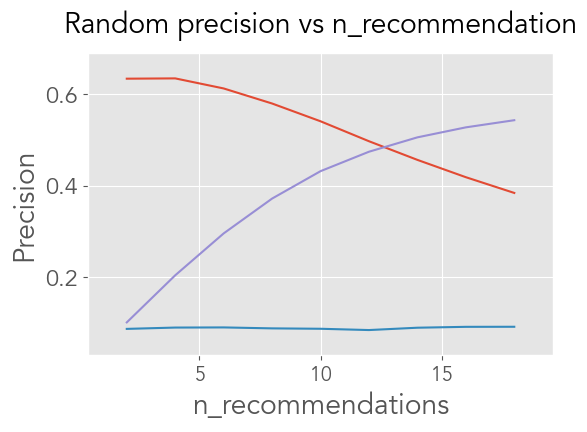

In [917]:
fig,ax = plt.subplots()
ax.plot(nrs, precisions, nrs, rand_precisions, nrs, recalls)
ax=ax_labels(ax, 'n_recommendations', 'Precision', 'Random precision vs n_recommendation' )

In [920]:
x = ['Random', 'NMF', 'SVD', 'SVDpp', 'Trail-Trail sim', 'User-User sim']
y= np.array([0.09, 0.136, 0.145, 0.217, 0.160, 0.623 ])/0.09

In [1214]:
y

array([1.        , 1.51111111, 1.61111111, 2.41111111, 1.77777778,
       6.92222222])

([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

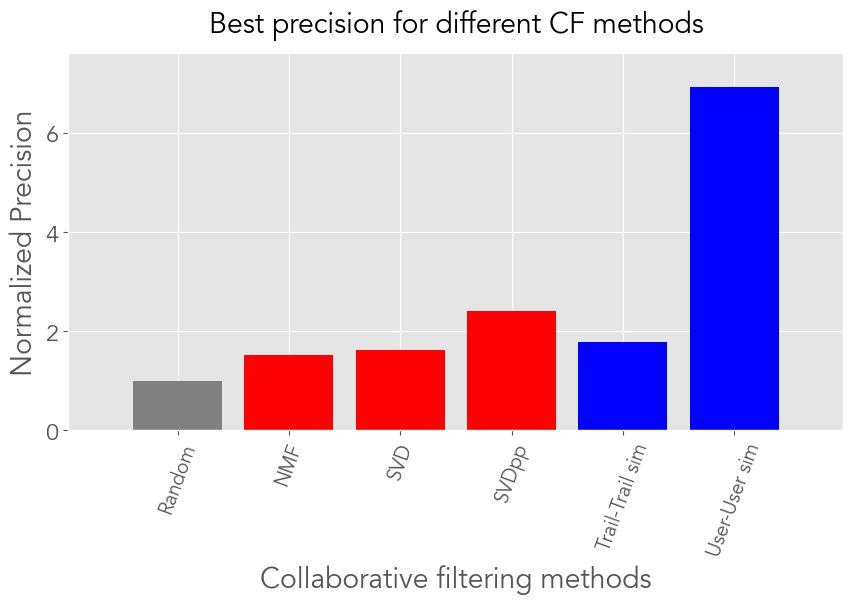

In [938]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x,y, color=['gray', 'red','red','red', 'blue', 'blue'])
ax=ax_labels(ax, 'Collaborative filtering methods', 'Normalized Precision', 'Best precision for different CF methods' )
plt.xticks(rotation=70)

## Pickling model

In [1168]:
%%time
reader=Reader()
data = Dataset.load_from_df(small_df[['user_id', 'trail_id', 'stars']], reader)
algo=KNNBasic(k=26)

trainset = data.build_full_trainset()
algo.fit(trainset)

k=20 ## Number of recommendations
super_user_thresh = 10

a= small_df.groupby('user_id').count().sort_values('trail', ascending=False)
super_users =list(a[a['trail']>=super_user_thresh].index)

pred = full_predictions(super_users)
recommendations = get_top_n(pred, k)

Computing the msd similarity matrix...
Done computing similarity matrix.
CPU times: user 9.82 s, sys: 65.4 ms, total: 9.89 s
Wall time: 9.91 s


In [1170]:
import pickle

filename = 'knn_recommendations.pickle'

with open(filename, 'wb') as handle:
    pickle.dump(recommendations, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(filename, 'rb') as handle:
    b = pickle.load(handle)

print (recommendations == b)

True


In [1222]:
with open(filename, 'rb') as handle:
    b = pickle.load(handle)

## For webapp, I need
1. small_df ==> to calculate the nearest neighbor
2. recommendations ==> to get recommendation for the neighbor
3. trail_indices ==> to get name of the trails from trail_id

In [981]:
## Define indices for trail_id : trail_name pairs 
trail_indices = small_df.groupby(['trail_url','trail']).sum().reset_index()
trail_indices.drop(columns={'stars','trail_avg_star','user_id','trail_id'},inplace=True)

trail_stats = small_df.drop_duplicates(subset=['trail_url']).drop(columns={'stars','date','user_id','trail'})
trail_indices = trail_indices.merge(trail_stats, how='inner', on='trail_url')

In [988]:
trail_indices.to_csv('knn_trail_indices.csv')

In [989]:
small_df.to_csv('small_df.csv')

## Calculating nearest neighbor for new user

### You have a list of trails you liked

add those to the small_df

In [1199]:
from scipy import sparse

## Let's say user input was recorded as [(trail_id, 5), (trail_id, 5), (trail_id,5)]
new_user_ratings = [(10,4), (21,5), (35,5)]
A = [10000 for i in new_user_ratings]
B= [i[0] for i in new_user_ratings ]
C = [i[1] for i in new_user_ratings]

d = {'user_id':A, 'trail_id':B, 'stars':C}
df_new = pd.DataFrame(data=d)
new_small_df = small_df.append(df_new)

sparse_mat = sparse.csr_matrix((new_small_df.stars, (new_small_df.user_id, new_small_df.trail_id,)))
A= (sparse_mat * sparse_mat.T)[-1,:].todense()
A = np.asarray(A).reshape(-1)
temp = sorted(A, reverse=True)

result = np.where(A == temp[1])[0][0]

old_user_rec = [i[0] for i in recommendations[result]]
new_user_rec = [x for x in old_user_rec if x not in B]

new_user_top_5 = new_user_rec[:5]

trail_indices.iloc[new_user_top_5]

,trail_url,trail,review_text,trail_avg_star,difficulty,distance,elevation,route_type,location,tag_list,short_description,trail_id
20,www.alltrails.com/trail/us/california/clouds-r...,Clouds Rest Trail via Tenaya Lake,"Awesome trail, great views and a killer workou...",5.0,hard,13 mi,3113 ft,Out & back,Yosemite National Park,"['Backpacking', 'Camping', 'Hiking', 'Forest',...",Clouds Rest Trail via Tenaya Lake is a 13 mile...,20
32,www.alltrails.com/trail/us/california/echo-mou...,Echo Mountain via Sam Merrill Trail,NaN,4.5,moderate,5.4 mi,1417 ft,Out & back,Angeles National Forest,"['Dogs on leash', 'Kid friendly', 'Hiking', 'V...",Echo Mountain via Sam Merrill Trail is a 5.4 m...,32
46,www.alltrails.com/trail/us/california/half-dom...,Half Dome Trail,"Awesome trail, great views and a killer workou...",5.0,hard,15 mi,5206 ft,Out & back,Yosemite National Park,"['Hiking', 'Nature trips', 'Rock climbing', 'S...",Half Dome Trail is a 15 mile heavily trafficke...,46
136,www.alltrails.com/trail/us/california/upper-yo...,Upper Yosemite Falls Trail,"Awesome trail, great views and a killer workou...",5.0,hard,7.6 mi,3231 ft,Out & back,Yosemite National Park,"['Hiking', 'Bird watching', 'River', 'Views', ...",Upper Yosemite Falls Trail is a 7.6 mile heavi...,136
137,www.alltrails.com/trail/us/california/vernal-a...,Vernal and Nevada Falls via the Mist Trail,Parking was pushed further back and the trail ...,5.0,hard,8.8 mi,2191 ft,Loop,Yosemite National Park,"['Hiking', 'Forest', 'Partially paved', 'River...",Vernal and Nevada Falls via the Mist Trail is ...,137
